In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score
import sklearn
from sklearn import preprocessing
#from SVM.ipynb import plot_confusion_matrix

import itertools

In [15]:
inspire=pd.read_pickle('bigREFSncgrams.pkl')
refs_of_refs=pd.DataFrame(np.loadtxt('reference_coreness.txt')[:,4:],columns=['core_ref_refs','non-core_ref_refs'])

In [17]:
inspire[['core_ref_refs','non-core_ref_refs']]=refs_of_refs[['core_ref_refs','non-core_ref_refs']]
inspire=inspire[['Text','Result','NC score', 'core refs','non-core refs','core_ref_refs','non-core_ref_refs','Category']]
inspire[['NC score', 'core refs','non-core refs','core_ref_refs','non-core_ref_refs']]=preprocessing.scale(inspire[['NC score', 'core refs','non-core refs','core_ref_refs','non-core_ref_refs']])
inspire=inspire.reindex(np.random.permutation(inspire.index))
inspire=inspire.reset_index(drop=True)
inspire.head()

,Text,Result,NC score,core refs,non-core refs,core_ref_refs,non-core_ref_refs,Category
0,A simplicial approach to multiplier bimonoids ...,0,-0.228434,-0.402655,-0.464878,-0.377423,-0.40955,math.CT
1,Complementary Families of the Fibonacci-Lucas ...,0,-0.228434,-0.402655,-0.464878,-0.377423,-0.40955,math.CO
2,"Infinite dimensional weak Dirichlet processes,...",0,-0.228434,-0.402655,-0.464878,-0.377423,-0.40955,math.PR
3,Graded identities of simple real graded divisi...,0,-0.228434,-0.402655,-0.464878,-0.377423,-0.40955,math.RA
4,11 x 11 Domineering is Solved: The first playe...,0,-0.228434,-0.402655,-0.464878,-0.377423,-0.40955,cs.AI


In [4]:
training_samples = 3 * len(inspire) // 5
validation_samples = len(inspire) // 5

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples]
inspire_test = inspire[training_samples + validation_samples:]

In [5]:
features=['core refs','non-core refs','core_ref_refs','non-core_ref_refs']
x_train = inspire_train[features]
y_train = inspire_train['Result']
x_val = inspire_val[features]
y_val = inspire_val['Result']
x_test = inspire_test[features]
y_test = inspire_test['Result']

In [6]:
def plot_confusion_matrix(cm, classes,normalize=False,title='confusion matrix',cmap=plt.cm.Purples):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix")
    print (cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center',color='white' if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')        

In [7]:
def Analyze(classifier,X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import classification_report
    clf=classifier.fit(X_train,Y_train)
   # score=clf.score(X_test,Y_test)
    Y_pred=clf.predict(X_test)
    target_names=['CORE','NON-CORE','Rejected']
    target_labels=[2,1,0]
    report=classification_report(Y_test,Y_pred,labels=target_labels,target_names=target_names)
    cm=cm=confusion_matrix(Y_test,Y_pred,labels=[2,1,0],)
    plt.figure()
    plot_confusion_matrix(cm,classes=target_names,normalize=True)
    plt.show()
    print(report)

In [10]:
def modeltesting(X_train, X_validation, Y_train, Y_validation):
    '''Function to test different models and produce a box plot to show the accuracies'''
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neural_network import MLPClassifier
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import SV
    from sklearn.ensemble import AdaBoostClassifier
    scoring = 'accuracy'
    # Spot Check Algorithms
    models = []
    models.append(('LogisticRegression', LogisticRegression()))
    #models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    #models.append(('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    models.append(('AdaBoost', AdaBoostClassifier()))
    models.append(('Naive Bayes', GaussianNB()))
    models.append(('Neural Network', MLPClassifier()))
    models.append(('LinearSVC', LinearSVC(max_iter=10,class_weight='balanced')))
    models.append(('SGDClassifier', SGDClassifier(max_iter=10,class_weight='balanced',loss='log',penalty='elasticnet')))
    models.append(('SVC', SVC(class_weight='balanced',probability=True,C=0.05,gamma=0.5)))
    
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=42)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())    
        print(msg)
        Analyze(model,X_train,Y_train,X_validation,Y_validation)
        
        
        
    fig = plt.figure()
    #fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    #pyplot.legend()
    plt.ylabel('Accuracy')
    ax.set_xticklabels(names,rotation=13)
    plt.show()

LogisticRegression: 0.921748 (0.039729)
Normalised confusion matrix
[[0.89568144 0.02972518 0.07459338]
 [0.11252269 0.42014519 0.46733212]
 [0.00495846 0.03055481 0.96448673]]


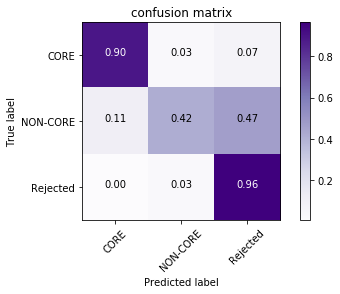

             precision    recall  f1-score   support

       CORE       0.91      0.90      0.90      1783
   NON-CORE       0.62      0.42      0.50      1102
   Rejected       0.92      0.96      0.94      7462

avg / total       0.88      0.89      0.89     10347

KNeighborsClassifier: 0.916851 (0.040800)
Normalised confusion matrix
[[0.89175547 0.0448682  0.06337633]
 [0.1107078  0.41833031 0.47096189]
 [0.00536049 0.03470919 0.95993031]]


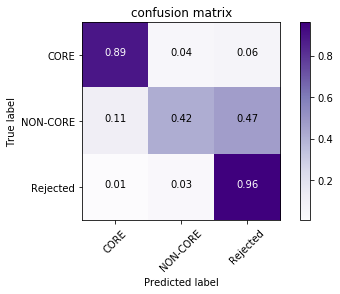

             precision    recall  f1-score   support

       CORE       0.91      0.89      0.90      1783
   NON-CORE       0.58      0.42      0.48      1102
   Rejected       0.92      0.96      0.94      7462

avg / total       0.88      0.89      0.88     10347

DecisionTreeClassifier: 0.898939 (0.046297)
Normalised confusion matrix
[[0.86371284 0.08076276 0.0555244 ]
 [0.146098   0.45825771 0.39564428]
 [0.01139105 0.06110962 0.92749933]]


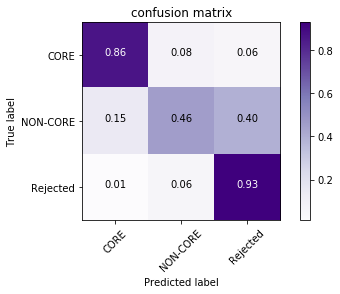

             precision    recall  f1-score   support

       CORE       0.86      0.86      0.86      1783
   NON-CORE       0.46      0.46      0.46      1102
   Rejected       0.93      0.93      0.93      7462

avg / total       0.87      0.87      0.87     10347

AdaBoost: 0.920975 (0.040187)
Normalised confusion matrix
[[0.90465508 0.03982053 0.0555244 ]
 [0.10980036 0.49818512 0.39201452]
 [0.00629858 0.04114179 0.95255964]]


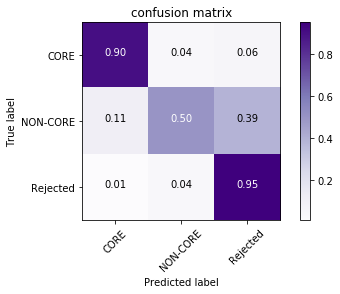

             precision    recall  f1-score   support

       CORE       0.91      0.90      0.91      1783
   NON-CORE       0.59      0.50      0.54      1102
   Rejected       0.93      0.95      0.94      7462

avg / total       0.89      0.90      0.89     10347

Naive Bayes: 0.909699 (0.046297)
Normalised confusion matrix
[[0.85866517 0.10768368 0.03365115]
 [0.06170599 0.64428312 0.29401089]
 [0.00134012 0.07745913 0.92120075]]


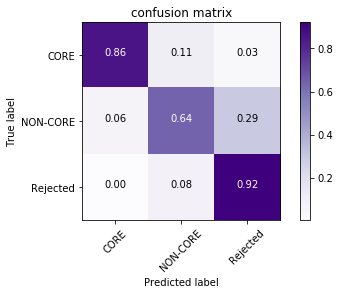

             precision    recall  f1-score   support

       CORE       0.95      0.86      0.90      1783
   NON-CORE       0.48      0.64      0.55      1102
   Rejected       0.95      0.92      0.93      7462

avg / total       0.90      0.88      0.89     10347

Neural Network: 0.924228 (0.038702)
Normalised confusion matrix
[[0.90689849 0.03701626 0.05608525]
 [0.11343013 0.46733212 0.41923775]
 [0.00629858 0.02854463 0.96515679]]


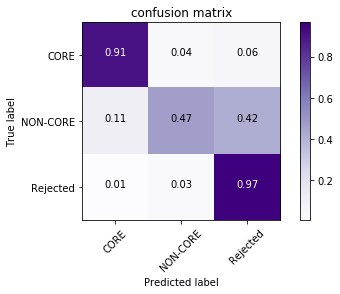

             precision    recall  f1-score   support

       CORE       0.90      0.91      0.91      1783
   NON-CORE       0.65      0.47      0.54      1102
   Rejected       0.93      0.97      0.95      7462

avg / total       0.89      0.90      0.90     10347

LinearSVC: 0.915594 (0.042684)
Normalised confusion matrix
[[0.91362872 0.02748177 0.05888951]
 [0.13793103 0.41923775 0.44283122]
 [0.00830876 0.02988475 0.96180649]]


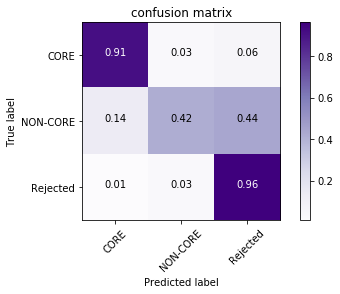

             precision    recall  f1-score   support

       CORE       0.88      0.91      0.90      1783
   NON-CORE       0.63      0.42      0.50      1102
   Rejected       0.92      0.96      0.94      7462

avg / total       0.89      0.90      0.89     10347

SGDClassifier: 0.915143 (0.045209)
Normalised confusion matrix
[[0.88839035 0.05720695 0.05440269]
 [0.0862069  0.62431942 0.28947368]
 [0.0032163  0.07330474 0.92347896]]


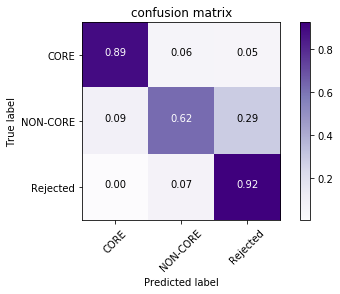

             precision    recall  f1-score   support

       CORE       0.93      0.89      0.91      1783
   NON-CORE       0.51      0.62      0.56      1102
   Rejected       0.94      0.92      0.93      7462

avg / total       0.90      0.89      0.89     10347

SVC: 0.870460 (0.068448)
Normalised confusion matrix
[[0.88222098 0.09422322 0.0235558 ]
 [0.08076225 0.76950998 0.14972777]
 [0.00254623 0.19069954 0.80675422]]


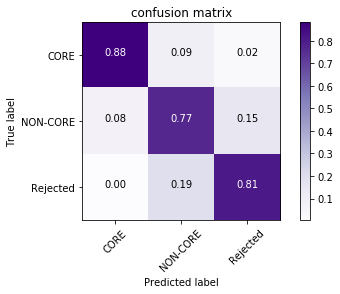

             precision    recall  f1-score   support

       CORE       0.94      0.88      0.91      1783
   NON-CORE       0.35      0.77      0.48      1102
   Rejected       0.97      0.81      0.88      7462

avg / total       0.90      0.82      0.84     10347



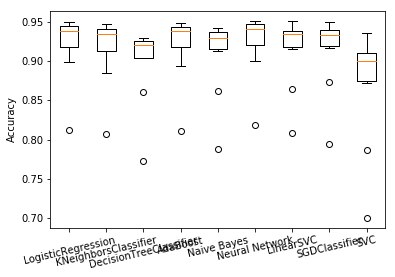

In [11]:
modeltesting(x_train, x_val, y_train, y_val)

In [13]:
SGD_clf=SGDClassifier(loss='log',class_weight='balanced')

/Users/parisa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


10347


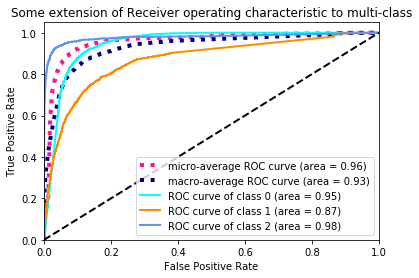

In [14]:
# Compute macro-average ROC curve 
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize
# First aggregate all false positive rates
n_classes=3
y_bin_test=label_binarize(y_val,classes=[0,1,2])
#y_bin_pred=label_binarize(SGDpred,classes=[0,1,2])
y_score = SGD_clf.fit(x_train, y_train).decision_function(x_val)

print (len(y_bin_test))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    lw = 2
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()